<a href="https://colab.research.google.com/github/bmalecki/animal-shelter-kaggle/blob/master/animal_shelter.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import clear_output

from tensorflow import keras
from tensorflow.keras import layers

tf.keras.backend.set_floatx('float64')


In [ ]:
data_df = pd.read_csv("drive/My Drive/animal-shelter/train.csv")
data_df

,ID,Animal ID,Name,DateTime,Date of Birth,Outcome Type,Animal Type,Sex upon Outcome,Age upon Outcome,Breed,Color
0,95779,A720945,Jeet,02/19/2016 07:11:00 PM,12/03/2015,Adoption,Dog,Intact Male,2 months,Rottweiler Mix,Tricolor
1,97632,A697146,NaN,02/19/2015 09:00:00 AM,06/18/2014,Transfer,Cat,Unknown,8 months,Domestic Shorthair Mix,Black/White
2,117838,A818712,Diamond,06/14/2020 11:34:00 AM,06/13/2019,Return to Owner,Dog,Intact Female,1 year,Siberian Husky,Red/White
3,10803,A673623,Shtinker,03/09/2014 12:13:00 PM,02/27/2011,Return to Owner,Dog,Spayed Female,3 years,Chihuahua Shorthair Mix,White/Brown
4,100331,A742185,NaN,01/18/2017 08:15:00 AM,01/17/2015,Euthanasia,Other,Unknown,2 years,Coyote,Brown
...,...,...,...,...,...,...,...,...,...,...,...
96325,50057,A753764,Princess,07/11/2017 01:19:00 PM,07/10/2015,Return to Owner,Dog,Intact Female,2 years,Pomeranian Mix,White/Brown
96326,98047,A714597,Crazy,02/02/2016 12:58:00 PM,09/25/2015,Adoption,Cat,Spayed Female,4 months,Domestic Shorthair Mix,Blue/White
96327,5192,A696264,Chocolate,02/08/2015 05:26:00 PM,02/01/2013,Euthanasia,Dog,Neutered Male,2 years,Pit Bull Mix,Chocolate/White
96328,77708,A670869,Gregory,01/19/2014 03:01:00 PM,10/31/2013,Transfer,Dog,Neutered Male,2 months,Pit Bull/Labrador Retriever,Black/White


In [ ]:
out_columns = data_df['Outcome Type'].unique()
out_columns.sort()
out_columns

array(['Adoption', 'Died', 'Disposal', 'Euthanasia', 'Missing',
       'Relocate', 'Return to Owner', 'Rto-Adopt', 'Transfer'],
      dtype=object)

In [ ]:
def mapAge(row):
  s = str(row['Age upon Outcome']).split()
  if pd.isna(row['Age upon Outcome']):
    s = '8 year'

  days = 2920; # 8 year

  if s[1].startswith("year"):
    days = int(s[0]) * 365
  if s[1].startswith("month"):
    days = int(s[0]) * 30
  if s[1].startswith("week"):
    days = int(s[0]) * 7
  if s[1].startswith("day"):
    days = int(s[0])
  
  if days < 0:
    days *= -1

  return days / (30*350) # normalize

def prepare_data(df):
  df['hasName'] = df.apply(lambda row : int(pd.notnull(row['Name'])), axis = 1)
  df['ageInDays'] = df.apply(mapAge, axis = 1)
  df['outcomeMonth'] = pd.DatetimeIndex(df['DateTime']).month

  df['Male'] = df.apply(lambda row : int('Male' in str(row['Sex upon Outcome'])), axis = 1)
  df['Female'] = df.apply(lambda row : int('Female' in str(row['Sex upon Outcome'])), axis = 1)
  df['Spayed'] = df.apply(lambda row : int('Spayed' in str(row['Sex upon Outcome'])), axis = 1)
  df['Neutered'] = df.apply(lambda row : int('Neutered' in str(row['Sex upon Outcome'])), axis = 1)
  df['Intact'] = df.apply(lambda row : int('Intact' in str(row['Sex upon Outcome'])), axis = 1)

  df['Tricolor'] = df.apply(lambda row : int('Tricolor' in str(row['Color'])), axis = 1)
  df['White'] = df.apply(lambda row : int('White' in str(row['Color'])), axis = 1)
  df['Gray'] = df.apply(lambda row : int('Gray' in str(row['Color'])), axis = 1)
  df['Brown'] = df.apply(lambda row : int('Brown' in str(row['Color'])), axis = 1)
  df['Orange'] = df.apply(lambda row : int('Orange' in str(row['Color'])), axis = 1)
  df['Black'] = df.apply(lambda row : int('Black' in str(row['Color'])), axis = 1)
  df['Blue'] = df.apply(lambda row : int('Blue' in str(row['Color'])), axis = 1)
  df['Red'] = df.apply(lambda row : int('Red' in str(row['Color'])), axis = 1)
  df['Tan'] = df.apply(lambda row : int('Tan' in str(row['Color'])), axis = 1)
  df['Pink'] = df.apply(lambda row : int('Pink' in str(row['Color'])), axis = 1)
  df['Chocolate'] = df.apply(lambda row : int('Chocolate' in str(row['Color'])), axis = 1)
  df['Green'] = df.apply(lambda row : int('Green' in str(row['Color'])), axis = 1)
  df['Yellow'] = df.apply(lambda row : int('Gold' in str(row['Color']) or 'Yellow' in str(row['Color'])), axis = 1)
  
  df['Mix'] = df.apply(lambda row : int('Mix' in str(row['Breed']) or '/' in str(row['Breed'])), axis = 1)
  df['Thoroughbred'] = df.apply(lambda row : int(not ('Mix' in str(row['Breed']) or '/' in str(row['Breed']))), axis = 1)

  df = pd.get_dummies(df, prefix='', prefix_sep='_', columns=['Animal Type'])
  df = pd.get_dummies(df, prefix='month', columns=['outcomeMonth'])

  df = df.drop(['Animal ID', 'Name', 'Age upon Outcome', 'DateTime',
                'Date of Birth', 'Breed', 'Sex upon Outcome', 'Color'],
               axis=1)

  return df

# df = prepare_data(data_df.sample(n=1000))
df = prepare_data(data_df.copy(deep=True).head(20000))
# df = prepare_data(data_df)
df

,ID,Outcome Type,hasName,ageInDays,Male,Female,Spayed,Neutered,Intact,Tricolor,White,Gray,Brown,Orange,Black,Blue,Red,Tan,Pink,Chocolate,Green,Yellow,Mix,Thoroughbred,_Bird,_Cat,_Dog,_Livestock,_Other,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12
0,95779,Adoption,1,0.005714,1,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0
1,97632,Transfer,0,0.022857,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
2,117838,Return to Owner,1,0.034762,0,1,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0
3,10803,Return to Owner,1,0.104286,0,1,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0
4,100331,Euthanasia,0,0.069524,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19995,10430,Euthanasia,0,0.002667,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0
19996,113458,Adoption,1,0.034762,0,1,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
19997,14254,Return to Owner,1,0.312857,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0
19998,33322,Transfer,0,0.034762,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0


In [ ]:
from sklearn.model_selection import train_test_split

shelter_features = df.columns.to_list()
shelter_features.remove('Outcome Type')

# Separate features and labels
shelter_X, shelter_y = df[shelter_features], df['Outcome Type']


# Split data 70%-30% into training set and test set
x_shelter_train, x_shelter_test, y_shelter_train, y_shelter_test = train_test_split(shelter_X, shelter_y,
                                                                                    test_size=0.30,
                                                                                    random_state=1,
                                                                                    stratify=shelter_y)

train_ids = x_shelter_train.pop('ID')
test_ids = x_shelter_test.pop('ID').values

print ('Training Set: %d, Test Set: %d \n' % (x_shelter_train.size, x_shelter_test.size))


Training Set: 546000, Test Set: 234000 



In [ ]:
from sklearn.linear_model import LogisticRegression

# Set regularization rate
reg = 0.1

# train a logistic regression model on the training set
model = LogisticRegression(C=1/reg, solver='lbfgs', multi_class='multinomial', max_iter=100).fit(x_shelter_train, y_shelter_train)
print (model)

LogisticRegression(C=10.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='multinomial', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [ ]:
len(shelter_prediction)

9000

In [94]:
import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from sklearn. metrics import classification_report

%matplotlib inline

shelter_prediction = model.predict(x_shelter_test)
print(classification_report(y_shelter_test, shelter_prediction))

                 precision    recall  f1-score   support

       Adoption       0.66      0.90      0.76      2626
           Died       0.00      0.00      0.00        56
       Disposal       0.00      0.00      0.00        30
     Euthanasia       0.71      0.55      0.62       407
        Missing       0.00      0.00      0.00         3
       Relocate       0.00      0.00      0.00         1
Return to Owner       0.53      0.38      0.44      1048
      Rto-Adopt       0.00      0.00      0.00        28
       Transfer       0.72      0.55      0.62      1801

       accuracy                           0.66      6000
      macro avg       0.29      0.26      0.27      6000
   weighted avg       0.65      0.66      0.64      6000



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


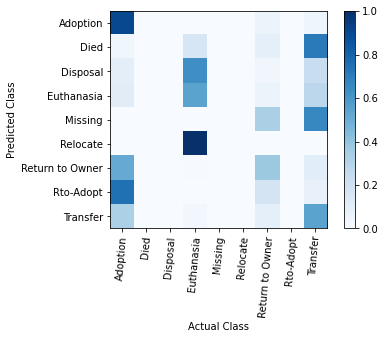

In [95]:
# Plot the confusion matrix
# simpler method below
cm = confusion_matrix(y_shelter_test, shelter_prediction)
# https://stackoverflow.com/questions/20927368/python-how-to-normalize-a-confusion-matrix#answer-47250703
cm = cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]  
plt.imshow(cm, interpolation="nearest", cmap=plt.cm.Blues)
plt.colorbar()
tick_marks = np.arange(len(out_columns))
plt.xticks(tick_marks, out_columns, rotation=85)
plt.yticks(tick_marks, out_columns)
plt.xlabel("Actual Class")
plt.ylabel("Predicted Class")
plt.show()

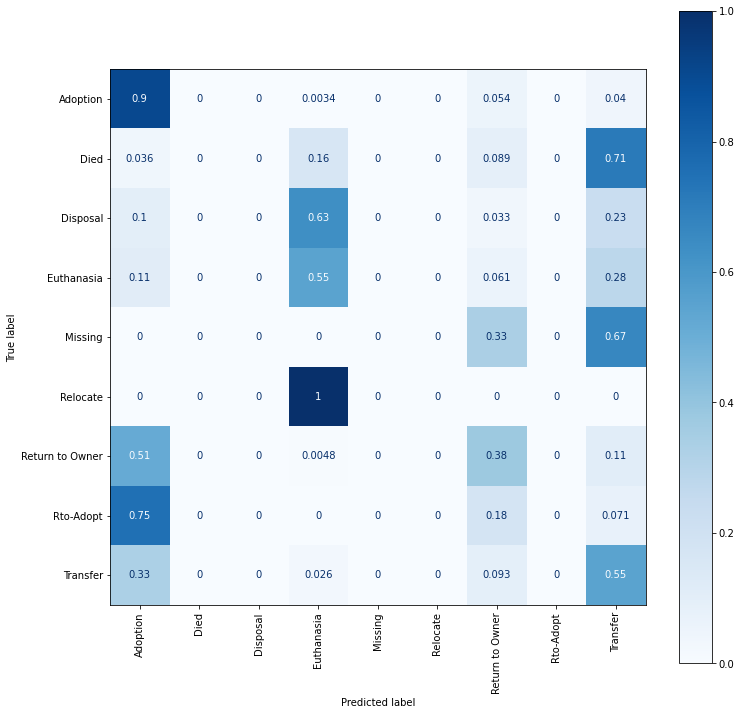

In [101]:
from sklearn.metrics import plot_confusion_matrix
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(9, 9))

# normalize https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
plot_confusion_matrix(model, x_shelter_test, y_shelter_test,
                                 display_labels=out_columns,
                                 cmap=plt.cm.Blues,
                                 normalize='true',
                                 xticks_rotation='vertical',
                                 ax=ax)

In [ ]:
shelter_prediction_proba = model.predict_proba(x_shelter_test)
shelter_prediction_proba = shelter_prediction_proba.round(2)

out_df = pd.DataFrame(shelter_prediction_proba, columns=out_columns)
out_df.insert(0, 'ID', test_ids)

out_df